In [1]:
!pip install sparse_lmm


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np

clinical_data = pd.read_csv('TCGA dataset/TCGA_Glioblastoma_(GBM)/TCGA.GBM.sampleMap_GBM_clinicalMatrix', sep='\t', index_col=0)
gene_data = pd.read_csv('TCGA dataset/TCGA_Glioblastoma_(GBM)/TCGA.GBM.sampleMap_HiSeqV2_PANCAN.gz', sep='\t', index_col=0)

In [5]:
clinical_data.head()

,CDE_DxAge,CDE_alk_chemoradiation_standard,CDE_chemo_adjuvant_alk,CDE_chemo_adjuvant_tmz,CDE_chemo_alk,CDE_chemo_alk_days,CDE_chemo_alk_long,CDE_chemo_tmz,CDE_chemo_tmz_days,CDE_chemo_tmz_long,...,_GENOMIC_ID_TCGA_GBM_exp_u133a,_GENOMIC_ID_TCGA_GBM_exp_HiSeqV2_PANCAN,_GENOMIC_ID_TCGA_GBM_RPPA_RBN,_GENOMIC_ID_TCGA_GBM_gistic2thd,_GENOMIC_ID_TCGA_GBM_PDMRNAseqCNV,_GENOMIC_ID_TCGA_GBM_mutation,_GENOMIC_ID_TCGA_GBM_exp_HiSeqV2_percentile,_GENOMIC_ID_TCGA_GBM_exp_HiSeqV2_exon,_GENOMIC_ID_TCGA_GBM_gistic2,_GENOMIC_ID_TCGA_GBM_hMethyl450
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0001-01,44.30,False,False,False,False,0.0,False,False,0.0,False,...,03c14838-bbab-4487-80c3-c5fdf6ec83f9,NaN,NaN,TCGA-02-0001-01C-01D-0182-01,NaN,NaN,NaN,NaN,TCGA-02-0001-01C-01D-0182-01,NaN
TCGA-02-0002-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-02-0003-01,50.21,False,False,False,False,0.0,False,False,0.0,False,...,4298ad72-e8eb-4749-95da-cce602107724,NaN,TCGA-02-0003-01A-21-1898-20,TCGA-02-0003-01A-01D-0182-01,NaN,TCGA-02-0003-01A-01D-1490-08,NaN,NaN,TCGA-02-0003-01A-01D-0182-01,NaN
TCGA-02-0004-01,59.18,True,True,True,True,110.0,True,True,110.0,True,...,1bc1d8d2-8c34-4b03-9275-38c68323816e,NaN,TCGA-02-0004-01A-21-1898-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-02-0006-01,56.17,False,True,True,True,61.0,True,True,61.0,True,...,NaN,NaN,NaN,TCGA-02-0006-01B-01D-0182-01,NaN,NaN,NaN,NaN,TCGA-02-0006-01B-01D-0182-01,NaN


In [6]:
gene_fullname = 'EGFR gene'
gene = 'egfr'
condition = 'obesity'
condition_col = 'initial_weight'
trait = 'Glioblastoma'

# Get the feature dimension of clinical data, and the number of genes
col_offset = len(clinical_data.columns)
num_genes = len(gene_data)
print(f'The clinical dataset has {col_offset} features, and the gene dataset includes {num_genes} genes')
gene_data.T

The clinical dataset has 128 features, and the gene dataset includes 20530 genes


sample,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
TCGA-27-1832-01,0.028908,3.696374,-0.531035,0.188528,-0.139478,0.73169,0.572906,-2.371346,-0.423399,-1.054472,...,2.816622,3.201883,1.839767,-1.28139,0.062723,1.500314,-0.621527,0.828105,-2.566833,0.010788
TCGA-27-1831-01,-1.352492,-3.196826,-0.531035,-1.512372,1.384022,2.26279,0.416806,-0.002946,-0.423399,-3.509972,...,0.119222,2.241083,1.851367,-1.28139,-1.363877,-1.968786,-0.957627,1.649605,-2.078833,1.153388
TCGA-28-5216-01,0.612008,2.056774,-0.531035,-0.023672,0.738322,0.99539,0.451306,2.004354,-0.423399,1.534028,...,0.014422,3.786083,0.898567,-1.28139,0.090923,-0.217986,-0.168127,-0.830495,-2.662333,0.027888
TCGA-16-0846-01,1.286508,1.949274,-0.531035,-0.148072,0.490322,0.85929,0.828606,1.356154,-0.423399,1.235928,...,0.970222,0.363483,1.707967,-1.28139,-1.115477,-0.399286,-0.399027,-0.022995,-4.423833,-0.507112
TCGA-28-5218-01,-0.921292,2.630174,-0.531035,0.058328,-0.141578,-0.52661,0.887706,4.620254,0.294201,2.664528,...,2.480322,-0.392417,1.276067,-1.28139,0.922223,2.508814,1.082773,0.590405,-0.312633,0.375288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-06-0210-01,-0.193992,3.629774,-0.531035,0.196728,0.598422,0.93429,0.275606,-2.297646,0.146101,0.635328,...,0.805022,0.186883,0.837267,-1.28139,0.460523,0.612814,-1.677727,-0.313995,-4.956033,0.212188
TCGA-06-0210-02,1.169908,3.229974,-0.531035,0.009428,0.204222,0.91279,0.843906,0.866554,0.147701,0.534128,...,0.230222,-0.030017,1.805867,-1.28139,0.066123,0.454514,1.195673,-0.178995,-3.237033,-0.577312
TCGA-02-0047-01,1.021008,1.647774,-0.531035,-0.351872,0.494722,1.29429,0.729706,-1.555146,-0.423399,2.319828,...,-0.748878,3.893183,1.209067,-1.28139,-0.373777,-0.333686,-0.108127,-1.109795,-4.368933,-0.521512
TCGA-06-0750-01,0.485908,1.846574,-0.531035,-0.013672,0.301122,0.68959,0.875506,0.283954,-0.423399,1.656828,...,1.941822,0.311283,0.756367,-1.28139,0.195323,0.846914,0.649573,0.884205,-1.549933,0.305288


In [14]:
# Merge clinical_data and gene_data on their indices - sample_ID, corresponding to each person
merged_data = clinical_data.join(gene_data.T)

merged_data.head()

,CDE_DxAge,CDE_alk_chemoradiation_standard,CDE_chemo_adjuvant_alk,CDE_chemo_adjuvant_tmz,CDE_chemo_alk,CDE_chemo_alk_days,CDE_chemo_alk_long,CDE_chemo_tmz,CDE_chemo_tmz_days,CDE_chemo_tmz_long,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0001-01,44.30,False,False,False,False,0.0,False,False,0.0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-02-0002-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-02-0003-01,50.21,False,False,False,False,0.0,False,False,0.0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-02-0004-01,59.18,True,True,True,True,110.0,True,True,110.0,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-02-0006-01,56.17,False,True,True,True,61.0,True,True,61.0,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Only select relevant columns
input_cols = [condition_col] + merged_data.columns[col_offset: col_offset + num_genes].tolist()
merged_data = merged_data[input_cols]

# Remove sample rows with missing columns.
threshold_rows = 0.8 * len(merged_data)
rows_after_any = len(merged_data.dropna(how='any'))

# Prefer "how='any'", if it does not discard too much data.
if rows_after_any >= threshold_rows:
    merged_data = merged_data.dropna(how='any')
else:
    merged_data = merged_data.dropna(how='all')
    merged_data = merged_data.fillna(0)

merged_data.head()

,initial_weight,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,0.0,1.021008,1.647774,-0.531035,-0.351872,0.494722,1.29429,0.729706,-1.555146,-0.423399,...,-0.748878,3.893183,1.209067,-1.28139,-0.373777,-0.333686,-0.108127,-1.109795,-4.368933,-0.521512
TCGA-02-0055-01,0.0,-0.864792,1.503874,-0.531035,-0.344872,0.832622,0.59429,-0.377494,-0.945046,-0.423399,...,0.674422,-0.945017,1.316667,-1.28139,0.018223,0.892514,-2.114027,-0.042395,-0.666033,0.774588
TCGA-02-2483-01,0.0,0.009808,-0.601726,-0.531035,-0.119072,0.968922,0.70029,0.957806,1.880154,-0.423399,...,-0.748878,-1.079017,0.871767,-1.28139,0.140823,-1.308686,0.805673,-1.449395,-4.345033,-0.006812
TCGA-02-2485-01,0.0,0.959008,4.193574,-0.531035,-0.371972,0.509622,0.57919,0.987006,-2.315146,0.856701,...,-0.748878,-0.621917,0.544567,-1.28139,0.216023,-0.576286,1.149873,-0.168395,-4.245433,-0.209912
TCGA-02-2486-01,0.0,0.412908,-0.923626,-0.531035,0.142528,0.719722,1.56289,0.418406,-1.564946,-0.423399,...,2.594022,-0.900217,2.752067,-1.28139,0.424823,1.443614,-2.604227,0.578805,-4.375333,0.508888


In [16]:

def mark_tumor(row_index):
    last_two_digits = int(row_index[-2:])

    if 1 <= last_two_digits <= 9:
        return 1
    elif 10 <= last_two_digits <= 19:
        return 0
    else:
        return -1

# Use the apply function to add the trait column to merged_data
merged_data[trait] = merged_data.index.to_series().apply(mark_tumor)

merged_data.head()

,initial_weight,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,...,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS,Glioblastoma
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,0.0,1.021008,1.647774,-0.531035,-0.351872,0.494722,1.29429,0.729706,-1.555146,-0.423399,...,3.893183,1.209067,-1.28139,-0.373777,-0.333686,-0.108127,-1.109795,-4.368933,-0.521512,1
TCGA-02-0055-01,0.0,-0.864792,1.503874,-0.531035,-0.344872,0.832622,0.59429,-0.377494,-0.945046,-0.423399,...,-0.945017,1.316667,-1.28139,0.018223,0.892514,-2.114027,-0.042395,-0.666033,0.774588,1
TCGA-02-2483-01,0.0,0.009808,-0.601726,-0.531035,-0.119072,0.968922,0.70029,0.957806,1.880154,-0.423399,...,-1.079017,0.871767,-1.28139,0.140823,-1.308686,0.805673,-1.449395,-4.345033,-0.006812,1
TCGA-02-2485-01,0.0,0.959008,4.193574,-0.531035,-0.371972,0.509622,0.57919,0.987006,-2.315146,0.856701,...,-0.621917,0.544567,-1.28139,0.216023,-0.576286,1.149873,-0.168395,-4.245433,-0.209912,1
TCGA-02-2486-01,0.0,0.412908,-0.923626,-0.531035,0.142528,0.719722,1.56289,0.418406,-1.564946,-0.423399,...,-0.900217,2.752067,-1.28139,0.424823,1.443614,-2.604227,0.578805,-4.375333,0.508888,1


In [17]:
input_cols = merged_data.columns.tolist()
gene_list = [col for col in input_cols if gene in col.lower()]

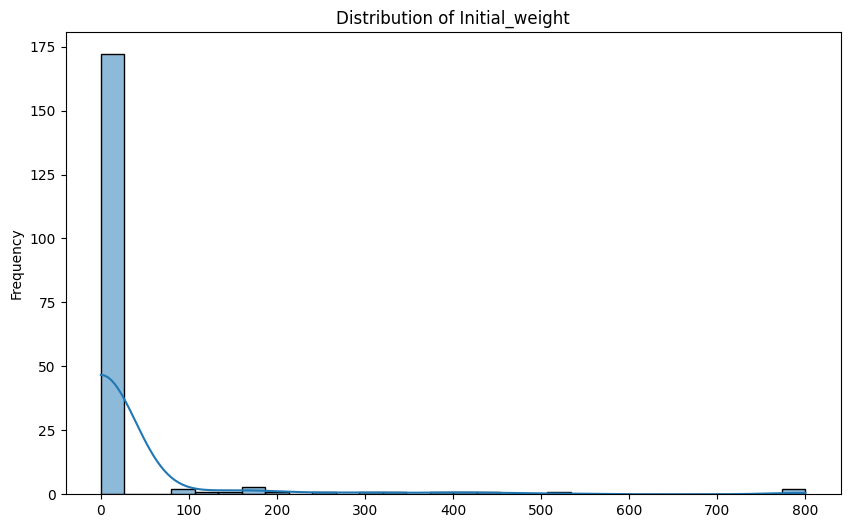

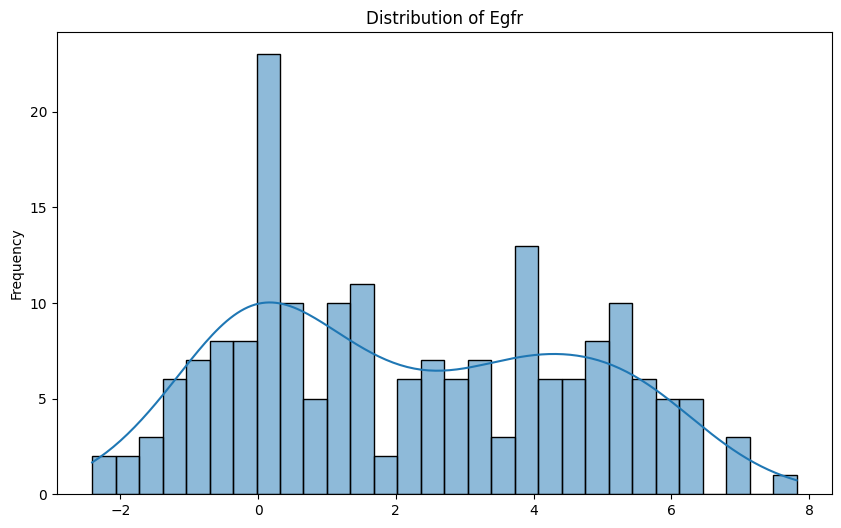

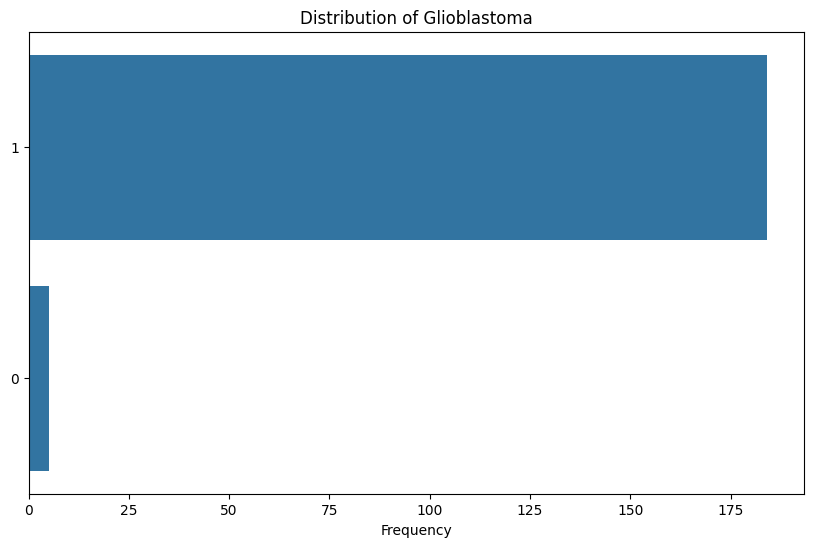

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_numeric_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Distribution of {column.capitalize()}')
    plt.xlabel('')
    plt.ylabel('Frequency')
    plt.show()

def plot_categorical_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.countplot(y=column, data=df, order=df[column].value_counts().index)
    plt.title(f'Distribution of {column.capitalize()}')
    plt.xlabel('Frequency')
    plt.ylabel('')
    plt.show()

def analyze_distributions(df, numerical_columns, categorical_columns):
    for col in numerical_columns:
        plot_numeric_distribution(df, col)

    for col in categorical_columns:
        plot_categorical_distribution(df, col)

# Sample usage:
analyze_distributions(merged_data, numerical_columns=[condition_col, *gene_list], categorical_columns=[trait])

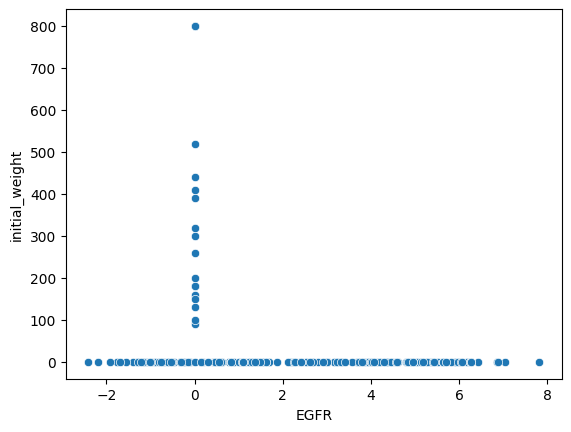

In [19]:
sns.scatterplot(data=merged_data, x='EGFR', y=condition_col)
plt.show()

In [20]:
# Convert "day_to_birth" to age in years
merged_data[condition_col] = (- merged_data[condition_col] / 365.25).astype(int)
merged_data = merged_data.rename(columns={condition_col: condition})
input_cols = merged_data.columns.tolist()

merged_data.head()

,obesity,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,...,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS,Glioblastoma
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,0,1.021008,1.647774,-0.531035,-0.351872,0.494722,1.29429,0.729706,-1.555146,-0.423399,...,3.893183,1.209067,-1.28139,-0.373777,-0.333686,-0.108127,-1.109795,-4.368933,-0.521512,1
TCGA-02-0055-01,0,-0.864792,1.503874,-0.531035,-0.344872,0.832622,0.59429,-0.377494,-0.945046,-0.423399,...,-0.945017,1.316667,-1.28139,0.018223,0.892514,-2.114027,-0.042395,-0.666033,0.774588,1
TCGA-02-2483-01,0,0.009808,-0.601726,-0.531035,-0.119072,0.968922,0.70029,0.957806,1.880154,-0.423399,...,-1.079017,0.871767,-1.28139,0.140823,-1.308686,0.805673,-1.449395,-4.345033,-0.006812,1
TCGA-02-2485-01,0,0.959008,4.193574,-0.531035,-0.371972,0.509622,0.57919,0.987006,-2.315146,0.856701,...,-0.621917,0.544567,-1.28139,0.216023,-0.576286,1.149873,-0.168395,-4.245433,-0.209912,1
TCGA-02-2486-01,0,0.412908,-0.923626,-0.531035,0.142528,0.719722,1.56289,0.418406,-1.564946,-0.423399,...,-0.900217,2.752067,-1.28139,0.424823,1.443614,-2.604227,0.578805,-4.375333,0.508888,1


In [21]:
import pandas as pd
from sparse_lmm import VariableSelection

# Select relevant columns and convert to numpy array
data_array = merged_data.values

# Normalize data
X = data_array
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
zero_std_columns = np.where(std == 0)[0]
X = (X - mean) / std
X[:, zero_std_columns] = 0

y = merged_data[trait].values

# Implementing k-fold cross-validation
def cross_validation(X, y, k=5):
    # Shuffle data
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X_shuffled = X[indices]
    y_shuffled = y[indices]

    fold_size = len(X) // k
    accuracies = []

    for i in range(k):
        # Split data into train and test based on the current fold
        test_indices = indices[i*fold_size : (i+1)*fold_size]
        train_indices = np.setdiff1d(indices, test_indices)

        X_train, X_test = X_shuffled[train_indices], X_shuffled[test_indices]
        y_train, y_test = y_shuffled[train_indices], y_shuffled[test_indices]

        # Use the precision_lasso package for regression
        var_select = VariableSelection()
        var_select.fit(X_train, y_train)
        predictions = var_select.predict(X_test)

        # Turn the predictions into binary values using a threshold of 0.5
        binary_predictions = (predictions > 0.5).astype(int)

        # Calculate accuracy for this fold
        accuracy = np.mean(binary_predictions == y_test)
        accuracies.append(accuracy)

    return np.mean(accuracies)

print(cross_validation(data_array, y))

C:\Users\Bobibob\AppData\Local\Temp\ipykernel_25160\2284219672.py:12: RuntimeWarning: invalid value encountered in divide
  X = (X - mean) / std
C:\Users\Bobibob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sparse_lmm\helpingMethods.py:49: RuntimeWarning: invalid value encountered in divide
  ts = beta / np.sqrt(var * sigma)
C:\Users\Bobibob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sparse_lmm\VariableSelection.py:183: RuntimeWarning: divide by zero encountered in log
  return -np.log(p), np.array(betas)


0.1701972242512783


In [22]:
# Conduct regression on the whole dataset
# Instantiate the VariableSelection class
var_select = VariableSelection()

# Fit the model
var_select.fit(X, y)

# Retrieve the coefficients
coefficients = var_select.getBeta().reshape(-1).tolist()
nlog_p_values = var_select.getNegLogP().reshape(-1).tolist()

In [23]:
# Print regression result

gene_result = []
condition_result = []

# Extract information related to the regressors
for var, coef, nlogp in zip(input_cols, coefficients, nlog_p_values):
    if gene in var.lower():
        gene_result.append((var, coef, np.exp(-nlogp)))
    if condition == var.lower():
        condition_result.append((var, coef, np.exp(-nlogp)))

regression_report = "Regression Results:\n\n"
regression_report += f"For {gene}:\n"
for variable_name, coefficient, p_value in gene_result:
    regression_report += f"{variable_name}: Coefficient = {coefficient}, p-value = {p_value}\n"

regression_report += f"\nFor {condition}:\n"
for variable_name, coefficient, p_value in condition_result:
    regression_report += f"{variable_name}: Coefficient = {coefficient}, p-value = {p_value}\n"

print(regression_report)

Regression Results:

For egfr:
EGFR: Coefficient = 0.016106842585058557, p-value = 0.07106807477379035

For obesity:
obesity: Coefficient = -2.429381067974566e-05, p-value = 0.98343673091986



In [24]:
# Generate hypothesis text

hypotheses_text = f'Hypothesis\n\n'
hypotheses_text += f'For the question "What is the relationship between {gene_fullname} and {trait} when considering the influence of {condition}?", the following hypotheses can be proposed:\n\n'
hypotheses_text += f'Null Hypothesis (H0): There is no significant association between the expression of the {gene_fullname} and {trait} when considering the influence of {condition}.\n\n'
hypotheses_text += f'Alternative Hypothesis (H1): There is an association between the expression of the {gene_fullname} and {trait} when considering the influence of {condition}.\n\n'

print(hypotheses_text)

Hypothesis

For the question "What is the relationship between EGFR gene and Glioblastoma when considering the influence of obesity?", the following hypotheses can be proposed:

Null Hypothesis (H0): There is no significant association between the expression of the EGFR gene and Glioblastoma when considering the influence of obesity.

Alternative Hypothesis (H1): There is an association between the expression of the EGFR gene and Glioblastoma when considering the influence of obesity.




In [25]:
# Interpretation of Regression Coefficients

threshold = 0.05
def interpret_coefficient(variable_name, coefficient, p_value, significance_level=0.05):
    interpretation = f"Variable: {variable_name}\n"

    if coefficient > 0:
        interpretation += "Coefficient is positive, "
    elif coefficient < 0:
        interpretation += "Coefficient is negative, "
    else:
        interpretation += "Coefficient is zero, "

    if p_value < threshold:
        interpretation += f"and it is statistically significant (p-value < {threshold}).\n\n"
    else:
        interpretation += f"and it is not statistically significant (p-value >= {threshold}).\n\n"

    return interpretation

# Create a report to interpret coefficients and p-values for all variables
interpretation_coefficient_report = "Interpretation of Regression Coefficients:\n\n"

for variable_name, coefficient, p_value in gene_result + condition_result:
    interpretation_coefficient_report += interpret_coefficient(variable_name, coefficient, p_value, threshold)

print(interpretation_coefficient_report)

Interpretation of Regression Coefficients:

Variable: EGFR
Coefficient is positive, and it is not statistically significant (p-value >= 0.05).

Variable: obesity
Coefficient is negative, and it is not statistically significant (p-value >= 0.05).




In [26]:
# Hypothesis Confirmation and Conclusion

# Create a function to determine if H0 or H1 is confirmed
def confirm_hypothesis(coefficient, p_value, variable_name, significance_level=0.05):
    if p_value >= significance_level:
        return f"H0 is not rejected: There is insufficient evidence to conclude a significant association between the expression of the {variable_name} gene and {trait} when considering the influence of {condition}."
    elif coefficient != 0 and p_value < significance_level:
        return f"H1 is confirmed: There is an association between the expression of the {variable_name} and {trait} when considering the influence of {condition}.\n\n"

hypothesis_confirmation_report = "Hypothesis Confirmation and Conclusion:\n\n"

for variable_name, coefficient, p_value in gene_result:
    confirmation = confirm_hypothesis(coefficient, p_value, variable_name, threshold)
    hypothesis_confirmation_report += f"Variable: {variable_name}\n"
    hypothesis_confirmation_report += f"Conclusion: {confirmation}\n\n"

print(hypothesis_confirmation_report)

Hypothesis Confirmation and Conclusion:

Variable: EGFR
Conclusion: H0 is not rejected: There is insufficient evidence to conclude a significant association between the expression of the EGFR gene and Glioblastoma when considering the influence of obesity.


